In [1]:
# Caso de Estudio: Retención de Usuarios - FitNess App

In [2]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Aquí estaba el error, ahora está corregido
import os

print("✅ Motor listo.")

✅ Motor listo.


In [3]:
# 2. Configuración de ubicación y rutas (Seguro y Privado)
import os

# Definimos cómo se llama la carpeta de tu proyecto
nombre_buscado = "Proyecto-FitnessApp"

# Lógica para saltar a la carpeta del proyecto si el kernel inicia en la carpeta de usuario
if nombre_buscado not in os.getcwd():
    # Construimos la ruta dinámica al escritorio
    ruta_escritorio = os.path.join(os.path.expanduser("~"), "Desktop", "TUP-UTN", "Materias", "Intro-Analisis-Datos", nombre_buscado)
    
    if os.path.exists(ruta_escritorio):
        os.chdir(ruta_escritorio)

# AQUÍ SE DEFINE LA VARIABLE QUE TE FALTA
path_raw = 'data/raw'

# Verificación final
if os.path.exists(path_raw):
    print(f"✅ Entorno listo en el proyecto: [{os.path.basename(os.getcwd())}]")
    print(f"✅ Carpeta de datos validada: {path_raw}")
else:
    print("❌ ERROR: No se encuentra la carpeta 'data/raw'.")
    print("📍 Ubicación actual de Python:", os.path.basename(os.getcwd()))

✅ Entorno listo en el proyecto: [Proyecto-FitnessApp]
✅ Carpeta de datos validada: data/raw


In [4]:
# 3. Carga de datos y creación de copias de seguridad
try:
    # Carga desde la ruta relativa validada anteriormente
    actividad_raw = pd.read_csv(os.path.join(path_raw, 'actividad_usuarios.csv'))
    demografia_raw = pd.read_json(os.path.join(path_raw, 'datos_demograficos.json'), encoding='utf-8-sig') # Nota: agregamos encoding por seguridad
    suscripciones_raw = pd.read_excel(os.path.join(path_raw, 'suscripciones_usuarios.xlsx'))
    progreso_raw = pd.read_csv(os.path.join(path_raw, 'progreso_planes.csv'))
    nutricion_raw = pd.read_excel(os.path.join(path_raw, 'interacciones_nutricion.xlsx'))

    # Creación de copias de trabajo
    df_actividad = actividad_raw.copy()
    df_demografia = demografia_raw.copy()
    df_suscripciones = suscripciones_raw.copy()
    df_progreso = progreso_raw.copy()
    df_nutricion = nutricion_raw.copy()

    print("✅ Datos cargados y copias de seguridad creadas exitosamente.")

except Exception as e:
    print(f"❌ Error al cargar los archivos: {e}")

✅ Datos cargados y copias de seguridad creadas exitosamente.


In [5]:
# 4. Auditoría de Identificadores (Caza de nulos y formatos)
print("🔎 CHEQUEO DE NULOS EN ID_USUARIO:")
print(f"Actividad: {df_actividad['ID_Usuario'].isnull().sum()}")
print(f"Demografía: {df_demografia['ID_Usuario'].isnull().sum()}")

# Chequeo de espacios en blanco (error común de Software Developer)
ejemplo_id = df_actividad['ID_Usuario'].iloc[0]
print(f"\n📏 Prueba de longitud del ID '{ejemplo_id}': {len(str(ejemplo_id))} caracteres")

# Verificamos si hay espacios que sobran
if len(str(ejemplo_id)) != len(str(ejemplo_id).strip()):
    print("⚠️ ALERTA: Se detectaron espacios en blanco en los IDs. Necesitan limpieza.")
else:
    print("✅ Formato de IDs parece limpio.")

🔎 CHEQUEO DE NULOS EN ID_USUARIO:
Actividad: 0
Demografía: 0

📏 Prueba de longitud del ID 'USR-04725': 9 caracteres
✅ Formato de IDs parece limpio.


In [6]:
# 5. Unificación de tablas (Merge Estratégico)
# Empezamos con Actividad y sumamos Demografía
df_maestro = df_actividad.merge(df_demografia, on='ID_Usuario', how='left')

# Sumamos Suscripciones
df_maestro = df_maestro.merge(df_suscripciones, on='ID_Usuario', how='left')

# Sumamos Nutrición (contando interacciones por usuario para no duplicar filas)
nutricion_resumen = df_nutricion.groupby('ID_Usuario').size().reset_index(name='Interacciones_Nutricion')
df_maestro = df_maestro.merge(nutricion_resumen, on='ID_Usuario', how='left')

# Rellenamos nulos en interacciones con 0 (quien no aparece es porque no la usó)
df_maestro['Interacciones_Nutricion'] = df_maestro['Interacciones_Nutricion'].fillna(0)

print(f"✅ Dataset Maestro creado.")
print(f"📊 Dimensiones finales: {df_maestro.shape[0]} filas y {df_maestro.shape[1]} columnas")

✅ Dataset Maestro creado.
📊 Dimensiones finales: 11600 filas y 17 columnas


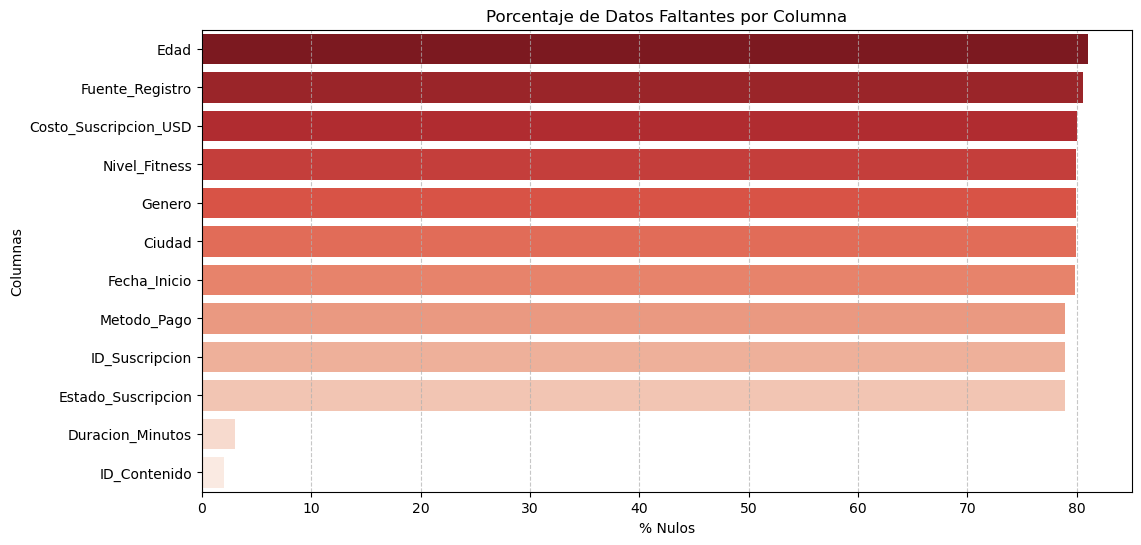

,Columnas,Nulos,% Nulos
6,Edad,9396,81.000000
9,Fuente_Registro,9344,80.551724
14,Costo_Suscripcion_USD,9282,80.017241
8,Nivel_Fitness,9276,79.965517
7,Genero,9276,79.965517
10,Ciudad,9276,79.965517
12,Fecha_Inicio,9259,79.818966
15,Metodo_Pago,9159,78.956897
11,ID_Suscripcion,9159,78.956897
13,Estado_Suscripcion,9159,78.956897


In [7]:
# 6. Diagnóstico de valores faltantes en el Dataset Maestro
nulos_conteo = df_maestro.isnull().sum()
nulos_porcentaje = (nulos_conteo / len(df_maestro)) * 100

df_nulos = pd.DataFrame({
    'Columnas': nulos_conteo.index,
    'Nulos': nulos_conteo.values,
    '% Nulos': nulos_porcentaje.values
}).sort_values(by='% Nulos', ascending=False)

# Visualización rápida
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_nulos[df_nulos['Nulos'] > 0], 
    x='% Nulos', 
    y='Columnas', 
    hue='Columnas',      # <--- Esto elimina el Warning
    palette='Reds_r', 
    legend=False         # <--- Esto mantiene el gráfico limpio
)
plt.title('Porcentaje de Datos Faltantes por Columna')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

display(df_nulos[df_nulos['Nulos'] > 0])

In [8]:
# 7. Limpieza Profunda Automática

# Separamos columnas por tipo de dato
cols_texto = df_maestro.select_dtypes(include=['object']).columns
cols_numeros = df_maestro.select_dtypes(include=['number']).columns

# A. Rellenamos TODO lo que sea texto con 'No Registrado'
df_maestro[cols_texto] = df_maestro[cols_texto].fillna('No Registrado')

# B. Rellenamos TODO lo que sea número con la mediana (o 0 si prefieres)
for col in cols_numeros:
    mediana = df_maestro[col].median()
    df_maestro[col] = df_maestro[col].fillna(mediana)

# C. Caso especial: Fecha_Inicio (Sintaxis actualizada)
if 'Fecha_Inicio' in df_maestro.columns:
    # Usamos los métodos directos ffill() y bfill() como sugiere el warning
    df_maestro['Fecha_Inicio'] = df_maestro['Fecha_Inicio'].ffill().bfill()

# Verificación final
nulos_final = df_maestro.isnull().sum().sum()
print(f"✅ Limpieza completada. Nulos restantes en el dataset: {nulos_final}")

if nulos_final == 0:
    print("🔥 ¡Perfecto! El Dataset Maestro está 100% limpio y listo para el análisis.")

✅ Limpieza completada. Nulos restantes en el dataset: 0
🔥 ¡Perfecto! El Dataset Maestro está 100% limpio y listo para el análisis.


In [9]:
# 8. Ingeniería de Variables: Tiempo y Comportamiento
from datetime import datetime

# Convertimos las fechas a formato datetime por seguridad
df_maestro['Fecha_Actividad'] = pd.to_datetime(df_maestro['Fecha_Actividad'])

# Definimos la "Fecha de Hoy" para el análisis (usamos la última fecha del dataset)
fecha_referencia = df_maestro['Fecha_Actividad'].max()

# A. Calculamos los días desde la última actividad por usuario
df_maestro['Dias_Inactivo'] = (fecha_referencia - df_maestro['Fecha_Actividad']).dt.days

# B. Identificamos a los usuarios en "Zona de Riesgo" (Churn)
# Definimos: Si no entrenó en los últimos 7 días, es un usuario en riesgo.
df_maestro['En_Riesgo'] = df_maestro['Dias_Inactivo'] > 7

print(f"✅ Variables de tiempo creadas.")
print(f"📊 Usuarios detectados en riesgo: {df_maestro['En_Riesgo'].sum()}")

✅ Variables de tiempo creadas.
📊 Usuarios detectados en riesgo: 11367


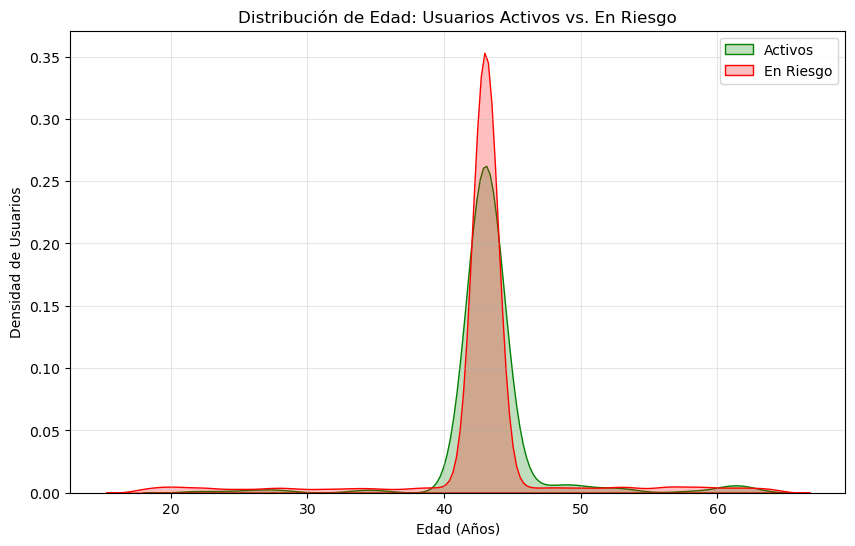

Promedio de edad por grupo:
En_Riesgo
False    43.403433
True     42.754025
Name: Edad, dtype: float64


In [10]:
# 9. Comparativa: ¿Influye la edad en el riesgo de abandono?
plt.figure(figsize=(10, 6))

# Filtramos para comparar los dos grupos
sns.kdeplot(data=df_maestro[df_maestro['En_Riesgo'] == False], x='Edad', label='Activos', fill=True, color='green')
sns.kdeplot(data=df_maestro[df_maestro['En_Riesgo'] == True], x='Edad', label='En Riesgo', fill=True, color='red')

plt.title('Distribución de Edad: Usuarios Activos vs. En Riesgo')
plt.xlabel('Edad (Años)')
plt.ylabel('Densidad de Usuarios')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Resumen estadístico
print("Promedio de edad por grupo:")
print(df_maestro.groupby('En_Riesgo')['Edad'].mean())

In [11]:
print(df_maestro.columns.tolist())

['ID_Actividad', 'ID_Usuario', 'Fecha_Actividad', 'Tipo_Evento', 'Duracion_Minutos', 'ID_Contenido', 'Edad', 'Genero', 'Nivel_Fitness', 'Fuente_Registro', 'Ciudad', 'ID_Suscripcion', 'Fecha_Inicio', 'Estado_Suscripcion', 'Costo_Suscripcion_USD', 'Metodo_Pago', 'Interacciones_Nutricion', 'Dias_Inactivo', 'En_Riesgo']


In [12]:
# 10. Fix: Integración de Planes y Re-limpieza
# Tomamos el plan más reciente por usuario para evitar duplicar registros de actividad
progreso_clean = df_progreso.sort_values('Fecha_Actualizacion', ascending=False).drop_duplicates('ID_Usuario')

# Unimos al maestro
df_maestro = df_maestro.merge(progreso_clean[['ID_Usuario', 'Tipo_Plan', 'Porcentaje_Completado']], 
                              on='ID_Usuario', how='left')

# Limpiamos los nuevos nulos generados por el merge
df_maestro['Tipo_Plan'] = df_maestro['Tipo_Plan'].fillna('Sin Plan Asignado')
df_maestro['Porcentaje_Completado'] = df_maestro['Porcentaje_Completado'].fillna(0)

print("✅ Columna 'Tipo_Plan' integrada y saneada.")
print(f"Columnas actuales: {df_maestro.columns.tolist()}")

✅ Columna 'Tipo_Plan' integrada y saneada.
Columnas actuales: ['ID_Actividad', 'ID_Usuario', 'Fecha_Actividad', 'Tipo_Evento', 'Duracion_Minutos', 'ID_Contenido', 'Edad', 'Genero', 'Nivel_Fitness', 'Fuente_Registro', 'Ciudad', 'ID_Suscripcion', 'Fecha_Inicio', 'Estado_Suscripcion', 'Costo_Suscripcion_USD', 'Metodo_Pago', 'Interacciones_Nutricion', 'Dias_Inactivo', 'En_Riesgo', 'Tipo_Plan', 'Porcentaje_Completado']


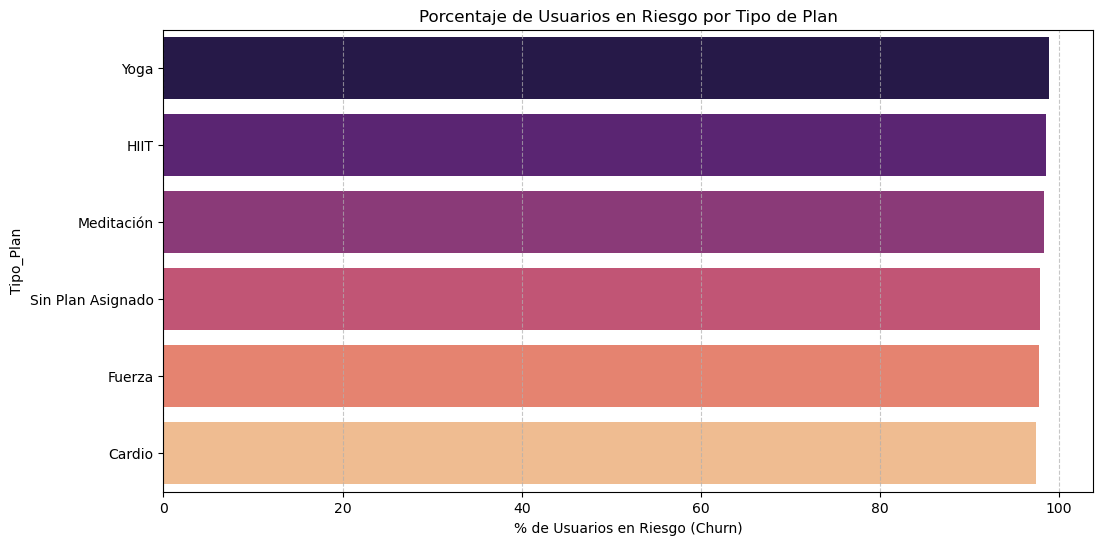

Ranking de Abandono por Plan (%):
Tipo_Plan
Yoga                 98.887653
HIIT                 98.568282
Meditación           98.349835
Sin Plan Asignado    97.850071
Fuerza               97.807933
Cardio               97.429907
Name: En_Riesgo, dtype: float64


In [13]:
# 11. ¿Qué planes tienen más usuarios en riesgo?
plt.figure(figsize=(12, 6))

# Calculamos el porcentaje de riesgo por tipo de plan
plan_riesgo = df_maestro.groupby('Tipo_Plan')['En_Riesgo'].mean().sort_values(ascending=False) * 100

sns.barplot(x=plan_riesgo.values, y=plan_riesgo.index, hue=plan_riesgo.index, palette='magma', legend=False)
plt.title('Porcentaje de Usuarios en Riesgo por Tipo de Plan')
plt.xlabel('% de Usuarios en Riesgo (Churn)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Ranking de Abandono por Plan (%):")
print(plan_riesgo)

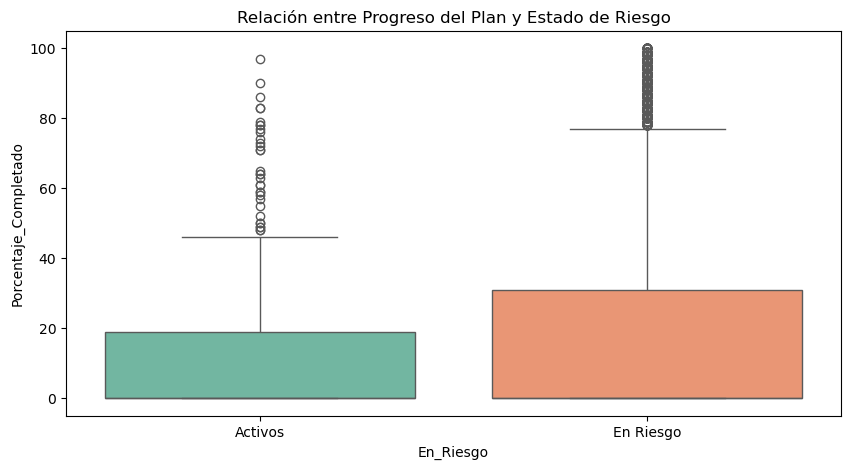

Promedio de progreso:
En_Riesgo
False    13.622318
True     18.171549
Name: Porcentaje_Completado, dtype: float64


In [14]:
# 12. Corregido: Relación entre Progreso y Riesgo
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_maestro, 
    x='En_Riesgo', 
    y='Porcentaje_Completado', 
    hue='En_Riesgo',    # Soluciona el Warning
    palette='Set2', 
    legend=False        # Limpia el gráfico
)
plt.title('Relación entre Progreso del Plan y Estado de Riesgo')
plt.xticks([0, 1], ['Activos', 'En Riesgo'])
plt.show()

print("Promedio de progreso:")
print(df_maestro.groupby('En_Riesgo')['Porcentaje_Completado'].mean())

In [15]:
# Exportación correcta siguiendo la arquitectura del proyecto
df_maestro.to_csv('data/processed/df_maestro_unificado.csv', index=False)